### This notebook is run by: 

`drive_calculate_C3S_GCMs_hindcast_tercile_probabilities.ipynb`   

For a given GCM, initial month, and period, it calculates the tercile climatology, saves the climatology in 

`/media/nicolasf/END19101/ICU/data/CDS/CLIMATOLOGY/{GCM}`

then calculates the probabilities for each year (for the given initial month) and saves them in 

`/media/nicolasf/END19101/ICU/data/CDS/{GCM}/tercile_probs/{varname.upper()}`


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr

# dask 
import dask 
from dask.diagnostics import ProgressBar

In [3]:
import pathlib
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import local functions for the processing of the C3S forecasts 

In [4]:
sys.path.append('../..')

In [5]:
from ICU_Water_Watch import C3S, domains

In [6]:
domain = domains.domains['C3S_download']

In [7]:
domain

[100, 240, -50, 30]

### parameters for papermill 

In [8]:
provider = 'CDS'
varname = 'tprate'
varname_out = 'precip'
period = 'seasonal'
GCM = 'ECMWF'
month = 1
quantile = 'quartile'

### list of GCMs 

In [9]:
list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP', 'JMA']

In [10]:
if GCM not in list_GCMs: 
    print(f"{GCM} is not in {', '.join(list_GCMs)}")

### path to the GCMs **hindcast datasets** and **climatologies** 

In [11]:
gcm_path = pathlib.Path(f'/media/nicolasf/END19101/ICU/data/{provider}')

### reads the hindcasts 

In [12]:
GCM

'ECMWF'

In [13]:
gcm_path.joinpath(f"{GCM}/{varname.upper()}")

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/ECMWF/TPRATE')

In [14]:
lfiles_hindcast = list(gcm_path.joinpath(f"{GCM}/{varname.upper()}").glob(f"ensemble_seas_forecasts_tprate_from_*_{month:02d}_{GCM}.netcdf"))

### only keep the years 1993 to 2016

In [15]:
lfiles_hindcast.sort()

In [16]:
def get_year(fname): 
    return int(fname.name.split("_")[5])

In [17]:
lfiles_hindcast = [x for x in lfiles_hindcast if get_year(x) <= 2016]

In [18]:
hindcast = xr.open_mfdataset(lfiles_hindcast, preprocess=C3S.preprocess_GCM)

In [19]:
hindcast = domains.extract_domain(hindcast, domain)

In [20]:
hindcast = C3S.convert_rainfall(hindcast, varin='tprate', varout='precip', leadvar='step', timevar='time', dropvar=True)


unit is m s**-1, converting to mm/day

now converting to mm/month, converted precipitation will be held in var = precip


In [21]:
if period == 'seasonal': 

    print("Calculating the seasonal (3 months) accumulations")

    hindcast = hindcast.rolling({'step':3}, min_periods=3, center=False).sum('step') 

    # get rid of the 2 first steps, which by definition contain missing values 

    hindcast = hindcast.sel(step=slice(3, None))

Calculating the seasonal (3 months) accumulations


### calculates the climatology 

In [22]:
hindcast.chunks

Frozen({'time': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'step': (3,), 'member': (25,), 'lat': (81,), 'lon': (121,)})

In [23]:
hindcast = hindcast.chunk({'time':-1, 'member':-1, 'lat':10, 'lon':10})

In [24]:
instances = len(hindcast.stack(instance=('time','member')).dropna('instance')['instance'])

In [25]:
instances

600

In [26]:
quartile_climatology = hindcast.quantile([0.25, 0.50, 0.75], dim=['time','member'])

In [27]:
with ProgressBar(): 
    quartile_climatology = quartile_climatology.compute()

[########################################] | 100% Completed |  4.6s


In [28]:
quartile_climatology.attrs['ninstances'] = instances

### save the climatology 

In [29]:
gcm_path

PosixPath('/media/nicolasf/END19101/ICU/data/CDS')

In [30]:
opath_clim = gcm_path.joinpath(f"CLIMATOLOGY/{GCM}/{varname.upper()}")

In [31]:
if not opath_clim.exists(): 
    opath_clim.mkdir(parents=True)

In [32]:
quartile_climatology.to_netcdf(opath_clim.joinpath(f"{GCM}_{period}_{quantile}_climatology_{month:02d}.netcdf"))

### Now derive the categories for the hindcast using the above climatology 

In [33]:
quartiles_category = C3S.get_GCM_category_digitize(hindcast, quartile_climatology.squeeze(), varname=varname_out, dim='quantile')

In [35]:
quartiles_category

,Array,Chunk
Bytes,134.60 MiB,1.37 MiB
Shape,"(24, 3, 25, 81, 121)","(24, 3, 25, 10, 10)"
Count,2015 Tasks,117 Chunks
Type,int64,numpy.ndarray


### Now calculate the probabilities as the proportion (along the `member` dimension) of members in each categories 

In [36]:
with ProgressBar(): 
    quartiles_category_percent = C3S.calculate_quantiles_probabilities(quartiles_category, ncategories=4)

[########################################] | 100% Completed |  2min 39.1s
[########################################] | 100% Completed |  2min 39.3s
[########################################] | 100% Completed |  2min 42.3s
[########################################] | 100% Completed |  2min 38.2s
[########################################] | 100% Completed |  2min 38.3s
[########################################] | 100% Completed |  2min 37.8s
[########################################] | 100% Completed |  2min 37.1s
[########################################] | 100% Completed |  2min 37.5s


### plots 

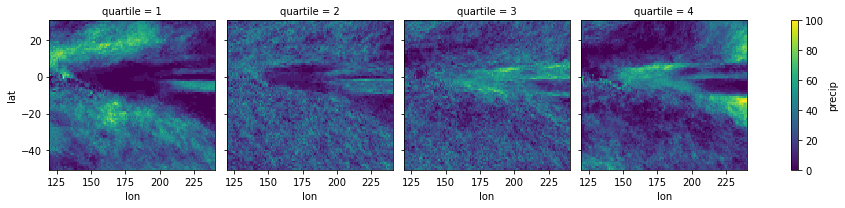

In [37]:
quartiles_category_percent.isel(time=0, step=0)[varname_out].plot(col=quantile)

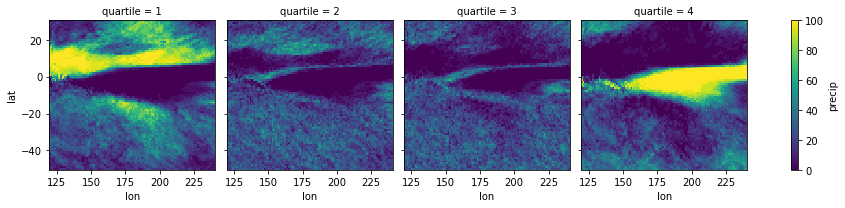

In [38]:
quartiles_category_percent.isel(time=-1, step=0)[varname_out].plot(col=quantile)

### most likely category 

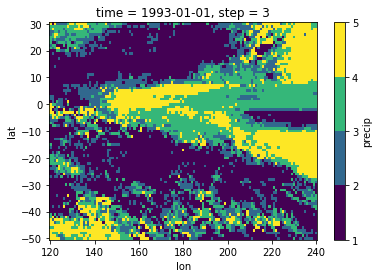

In [39]:
quartiles_category_percent.idxmax(dim=quantile)[varname_out].isel(time=0, step=0).plot(levels=[1,2,3,4,5])

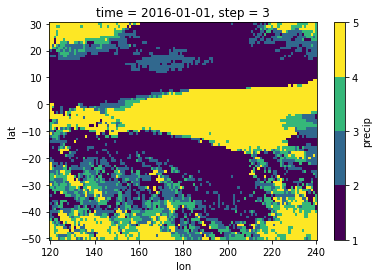

In [40]:
quartiles_category_percent.idxmax(dim=quantile)[varname_out].isel(time=-1, step=0).plot(levels=[1,2,3,4,5])

In [41]:
GCM

'ECMWF'

In [42]:
period 

'seasonal'

In [43]:
quantile

'quartile'

### now saves the tercile probabilities for each year, for the corresponding month 

In [44]:
opath_probs = gcm_path.joinpath(f"{GCM}/{quantile}_probs/{varname.upper()}")

In [45]:
if not opath_probs.exists(): 
    opath_probs.mkdir(parents=True)

In [46]:
for date in quartiles_category_percent.time.to_index(): 
    sub = quartiles_category_percent.sel(time=date)
    sub = sub.expand_dims({'time':[date]})
    sub.to_netcdf(opath_probs.joinpath(f"{GCM}_{period}_{quantile}s_probs_{date:%Y-%m}.netcdf"))